In [ ]:
import os, random, argparse, pandas as pd, numpy as np, seaborn as sns
from tqdm import tqdm
import torch, torch.nn as nn


# set random seed
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
SEED = 10
random.seed(SEED)
np.random.seed(SEED)
torch.random.manual_seed(SEED)


# load package requirments
from DeepRUOT.losses import MMD_loss, OT_loss1, OT_loss2, Density_loss, Local_density_loss 
from DeepRUOT.utils import group_extract, sample, to_np, generate_steps, cal_mass_loss, parser, _valid_criterions
from DeepRUOT.plots import plot_comparision, plot_losses
from DeepRUOT.train import train_un1
from DeepRUOT.models import velocityNet, growthNet, scoreNet, dediffusionNet, indediffusionNet, FNet, ODEFunc2
from DeepRUOT.constants import ROOT_DIR, DATA_DIR, NTBK_DIR, IMGS_DIR, RES_DIR
from DeepRUOT.exp import setup_exp
from DeepRUOT.eval import generate_plot_data
from torchdiffeq import odeint_adjoint as odeint
#from torchdiffeq import odeint

# for geodesic learning
from scipy.spatial import distance_matrix
from sklearn.gaussian_process.kernels import RBF
from sklearn.manifold import MDS

In [ ]:
import torch.optim as optim

dim=2
f_net = FNet(in_out_dim=dim, hidden_dim=128, n_hiddens=3, activation='leakyrelu')


import sys

# Simulate the command-line arguments
sys.argv = [
    'DeepRUOT Training',
    '-d', 'file',
    '-c', 'ot1',
    '-n', 'simulation_gene',
]

args = parser.parse_args()
opts = vars(args)

# Display the parsed arguments
print(opts)

device = torch.device('cuda')
device


{'dataset': 'file', 'time_col': None, 'name': 'simulation_gene', 'output_dir': '/lustre/home/2301110060/DeepRUOT/results', 'local_epochs': 5, 'epochs': 15, 'local_post_epochs': 5, 'criterion': 'ot1', 'batches': 100, 'cuda': True, 'sample_size': 100, 'sample_with_replacement': False, 'hold_one_out': True, 'hold_out': 'random', 'apply_losses_in_time': True, 'top_k': 5, 'hinge_value': 0.01, 'use_density_loss': True, 'use_local_density': False, 'lambda_density': 1.0, 'lambda_density_local': 1.0, 'lambda_local': 0.2, 'lambda_global': 0.8, 'model_layers': [64], 'use_geo': False, 'geo_layers': [32], 'geo_features': 5, 'n_points': 100, 'n_trajectories': 30, 'n_bins': 100}


device(type='cuda')

In [ ]:
df=pd.read_csv(DATA_DIR + '/simulation_gene_data.csv')
 # make output dir
if not os.path.isdir(opts['output_dir']):
    os.makedirs(opts['output_dir'])
exp_dir, logger = setup_exp(opts['output_dir'], opts, opts['name'])
  # load dataset
logger.info(f'Loading dataset')


In [ ]:
 # setup groups
groups = sorted(df.samples.unique())
steps = generate_steps(groups)
logger.info(f'Defining model')
use_geo = opts['use_geo']
model_layers = opts['model_layers']
model_features = len(df.columns) - 1

logger.info(f'Defining optimizer and criterion')
optimizer = torch.optim.Adam(f_net.parameters())

opts['criterion']='ot1'
criterion =  _valid_criterions[opts['criterion']]()

logger.info(f'Extracting parameters')
use_cuda = torch.cuda.is_available() and opts['cuda']
sample_size = (opts['sample_size'], )
sample_with_replacement = opts['sample_with_replacement' ]
apply_losses_in_time = opts['apply_losses_in_time']


n_local_epochs = opts['local_epochs']
n_epochs = opts['epochs']
n_post_local_epochs = opts['local_post_epochs']
n_batches = opts['batches']

hold_one_out = opts['hold_one_out']
hold_out = opts['hold_out']
    
hinge_value = opts['hinge_value']
top_k = opts['top_k']
lambda_density = opts['lambda_density']
lambda_density_local = opts['lambda_density_local']
use_density_loss = opts['use_density_loss']
use_local_density = opts['use_local_density']
    
lambda_local = opts['lambda_local']
lambda_global = opts['lambda_global']

n_points=opts['n_points']
n_trajectories=opts['n_trajectories'] 
n_bins=opts['n_bins']
    
    
local_losses = {f'{t0}:{t1}':[] for (t0, t1) in steps}
batch_losses = []
globe_losses = []

In [ ]:
f_net=f_net.to(device)

In [ ]:
initial_size=df[df['samples']==0].x1.shape[0]
initial_size

400

In [ ]:
sample_sizes = df.groupby('samples').size()
ref0 = sample_sizes / sample_sizes.iloc[0]  
relative_mass = torch.tensor(ref0.values) 
relative_mass

tensor([1.0000, 1.1050, 1.3250, 1.7250, 2.4225], dtype=torch.float64)

In [ ]:
sample_size = (df[df['samples']==0.0].values.shape[0],)

### PreTrain velocity and growth

In [9]:
    if n_local_epochs > 0:
        logger.info(f'Beginning pretraining')
        for epoch in tqdm(range(1), desc='Pretraining Epoch'):
            l_loss, b_loss, g_loss = train_un1(
                f_net, df, groups, optimizer,50, 
                criterion = criterion, use_cuda = use_cuda,
                local_loss=True, global_loss=False, apply_losses_in_time=apply_losses_in_time,
                hold_one_out=hold_one_out, hold_out=hold_out, 
                 hinge_value=hinge_value, lambda_ot=0.1, lambda_mass=1, lambda_energy=0.001,
                 use_pinn=False, use_penalty=False,use_density_loss=False,lambda_density=10,
                top_k = top_k, sample_size = sample_size,relative_mass=relative_mass,initial_size=initial_size,
                sample_with_replacement = sample_with_replacement, logger=logger, device=device,best_model_path=exp_dir+'/best_model'
            )
            for k, v in l_loss.items():  
                local_losses[k].extend(v)
            batch_losses.extend(b_loss)
            globe_losses.extend(g_loss)


Pretraining Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

begin local loss


  0%|          | 0/50 [00:00<?, ?it/s]

Otloss
tensor(0.6566, device='cuda:0', grad_fn=<SumBackward0>)
mass loss
tensor(0.3542, device='cuda:0', grad_fn=<PowBackward0>)
Otloss
tensor(2.1351, device='cuda:0', grad_fn=<SumBackward0>)
mass loss
tensor(0.5532, device='cuda:0', grad_fn=<PowBackward0>)
Otloss
tensor(2.9711, device='cuda:0', grad_fn=<SumBackward0>)
mass loss
tensor(1.4927, device='cuda:0', grad_fn=<PowBackward0>)
Otloss
tensor(2.5609, device='cuda:0', grad_fn=<SumBackward0>)
mass loss
tensor(3.6765, device='cuda:0', grad_fn=<PowBackward0>)
New minimum otloss found: 2.560936689376831. Model saved.
Otloss
tensor(0.3903, device='cuda:0', grad_fn=<SumBackward0>)
mass loss
tensor(0.3421, device='cuda:0', grad_fn=<PowBackward0>)
Otloss
tensor(1.0585, device='cuda:0', grad_fn=<SumBackward0>)
mass loss
tensor(0.5650, device='cuda:0', grad_fn=<PowBackward0>)
Otloss
tensor(1.1458, device='cuda:0', grad_fn=<SumBackward0>)
mass loss
tensor(0.6276, device='cuda:0', grad_fn=<PowBackward0>)
Otloss
tensor(0.8818, device='cuda:0', 

Pretraining Epoch: 100%|██████████| 1/1 [01:53<00:00, 113.27s/it]


In [10]:
f_net.load_state_dict(torch.load(os.path.join(exp_dir+'/best_model'),map_location=torch.device('cpu')))
f_net.to(device)
for param in f_net.g_net.parameters():
    param.requires_grad = False


In [18]:
    if n_local_epochs > 0:
        logger.info(f'Beginning pretraining')
        for epoch in tqdm(range(1), desc='Pretraining Epoch'):
            l_loss, b_loss, g_loss = train_un1(
                f_net, df, groups, optimizer,30, 
                criterion = criterion, use_cuda = use_cuda,
                local_loss=True, global_loss=False, apply_losses_in_time=apply_losses_in_time,
                hold_one_out=hold_one_out, hold_out=hold_out, 
                 hinge_value=hinge_value, lambda_ot=0.1, lambda_mass=0, lambda_energy=0.001,
                 use_pinn=False, use_penalty=False,use_density_loss=False,lambda_density=10,
                top_k = top_k, sample_size = sample_size,relative_mass=relative_mass,initial_size=initial_size,
                sample_with_replacement = sample_with_replacement, logger=logger, device=device,best_model_path=exp_dir+'/best_model'
            )
            for k, v in l_loss.items():  
                local_losses[k].extend(v)
            batch_losses.extend(b_loss)
            globe_losses.extend(g_loss)


Pretraining Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

begin local loss


  0%|          | 0/30 [00:00<?, ?it/s]

Otloss
tensor(0.0116, device='cuda:0', grad_fn=<SumBackward0>)
mass loss
tensor(0.0149, device='cuda:0', grad_fn=<PowBackward0>)
Otloss
tensor(0.0160, device='cuda:0', grad_fn=<SumBackward0>)
mass loss
tensor(0.0319, device='cuda:0', grad_fn=<PowBackward0>)
Otloss
tensor(0.0311, device='cuda:0', grad_fn=<SumBackward0>)
mass loss
tensor(0.1446, device='cuda:0', grad_fn=<PowBackward0>)
Otloss
tensor(0.0669, device='cuda:0', grad_fn=<SumBackward0>)
mass loss
tensor(0.5307, device='cuda:0', grad_fn=<PowBackward0>)
New minimum otloss found: 0.06685015559196472. Model saved.
Otloss
tensor(0.0185, device='cuda:0', grad_fn=<SumBackward0>)
mass loss
tensor(0.0114, device='cuda:0', grad_fn=<PowBackward0>)
Otloss
tensor(0.0609, device='cuda:0', grad_fn=<SumBackward0>)
mass loss
tensor(0.0896, device='cuda:0', grad_fn=<PowBackward0>)
Otloss
tensor(0.0844, device='cuda:0', grad_fn=<SumBackward0>)
mass loss
tensor(0.6742, device='cuda:0', grad_fn=<PowBackward0>)
Otloss
tensor(0.0713, device='cuda:0'

Pretraining Epoch: 100%|██████████| 1/1 [01:02<00:00, 62.06s/it]


In [19]:
f_net.load_state_dict(torch.load(os.path.join(exp_dir+'/best_model'),map_location=torch.device('cpu')))

<All keys matched successfully>

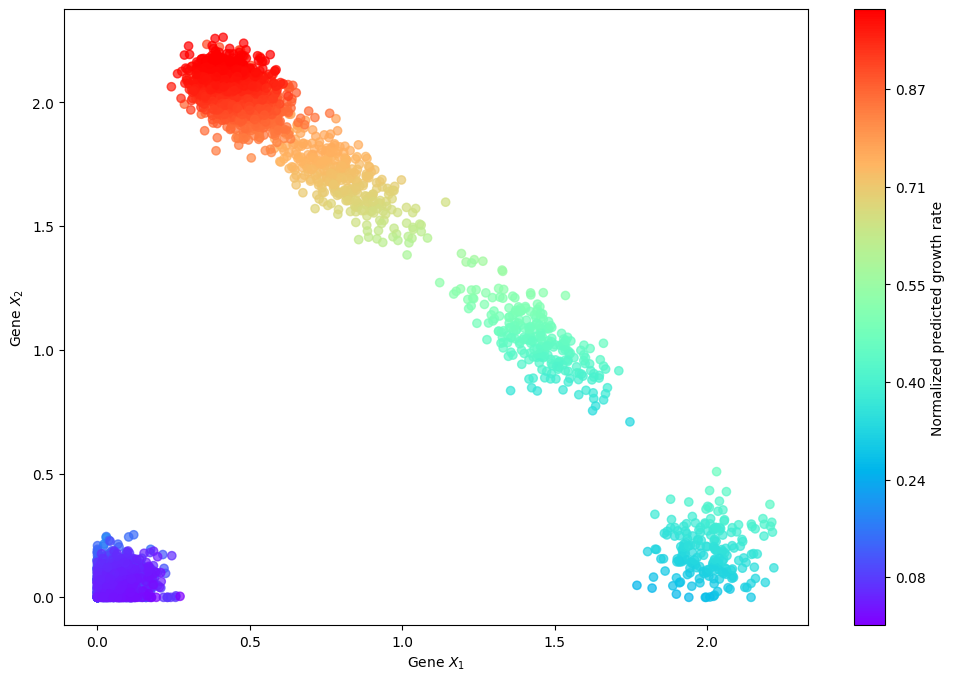

In [13]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_g_values(df, f_net, device=device, output_file='plot.pdf'):
    time_points = df['samples'].unique()
    
    data_by_time = {}
    
    for time in time_points:
        subset = df[df['samples'] == time]
        x = torch.tensor(subset['x1'].values, dtype=torch.float32).to(device)
        y = torch.tensor(subset['x2'].values, dtype=torch.float32).to(device)
        data = torch.stack([x, y], dim=1)
        
        with torch.no_grad():
            t = torch.tensor([time], dtype=torch.float32).to(device)
            _, g, _, _ = f_net(t, data)
        
        data_by_time[time] = {'data': subset, 'g_values': g.detach().cpu().numpy()}
    
    all_g_values = np.concatenate([content['g_values'] for content in data_by_time.values()])
    
    vmax_value = np.percentile(all_g_values, 99)
    
    norm = plt.Normalize(vmin=all_g_values.min(), vmax=vmax_value, clip=True)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for time, content in data_by_time.items():
        subset = content['data']
        g_values = content['g_values']
        x = subset['x1']
        y = subset['x2']
        
        colors = plt.cm.rainbow(norm(g_values))
        
        ax.scatter(x, y, color=colors, label=f'Time {time}', alpha=0.7, marker='o')
    
    ax.set_xlabel('Gene $X_1$')
    ax.set_ylabel('Gene $X_2$')
    
    sm = plt.cm.ScalarMappable(cmap='rainbow', norm=norm)
    sm.set_array(all_g_values)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Normalized predicted growth rate')
    
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{norm(x):.2f}'))
    
    plt.show()

plot_g_values(df, f_net, output_file='gene_growth_pre_post.pdf')

In [20]:
    # generate plot data
    f_net.to('cuda')
    generated, trajectories = generate_plot_data(
        f_net, df, n_points=400, n_trajectories=50, n_bins=100, 
        sample_with_replacement=True, use_cuda=use_cuda, samples_key='samples',
        logger=logger
    )


tensor([0., 1., 2., 3., 4.], device='cuda:0')
<class 'torch.Tensor'>
tensor([0.0000, 0.0404, 0.0808, 0.1212, 0.1616, 0.2020, 0.2424, 0.2828, 0.3232,
        0.3636, 0.4040, 0.4444, 0.4848, 0.5253, 0.5657, 0.6061, 0.6465, 0.6869,
        0.7273, 0.7677, 0.8081, 0.8485, 0.8889, 0.9293, 0.9697, 1.0101, 1.0505,
        1.0909, 1.1313, 1.1717, 1.2121, 1.2525, 1.2929, 1.3333, 1.3737, 1.4141,
        1.4545, 1.4949, 1.5354, 1.5758, 1.6162, 1.6566, 1.6970, 1.7374, 1.7778,
        1.8182, 1.8586, 1.8990, 1.9394, 1.9798, 2.0202, 2.0606, 2.1010, 2.1414,
        2.1818, 2.2222, 2.2626, 2.3030, 2.3434, 2.3838, 2.4242, 2.4646, 2.5051,
        2.5455, 2.5859, 2.6263, 2.6667, 2.7071, 2.7475, 2.7879, 2.8283, 2.8687,
        2.9091, 2.9495, 2.9899, 3.0303, 3.0707, 3.1111, 3.1515, 3.1919, 3.2323,
        3.2727, 3.3131, 3.3535, 3.3939, 3.4343, 3.4747, 3.5152, 3.5556, 3.5960,
        3.6364, 3.6768, 3.7172, 3.7576, 3.7980, 3.8384, 3.8788, 3.9192, 3.9596,
        4.0000], device='cuda:0')
<class 'torch.Ten

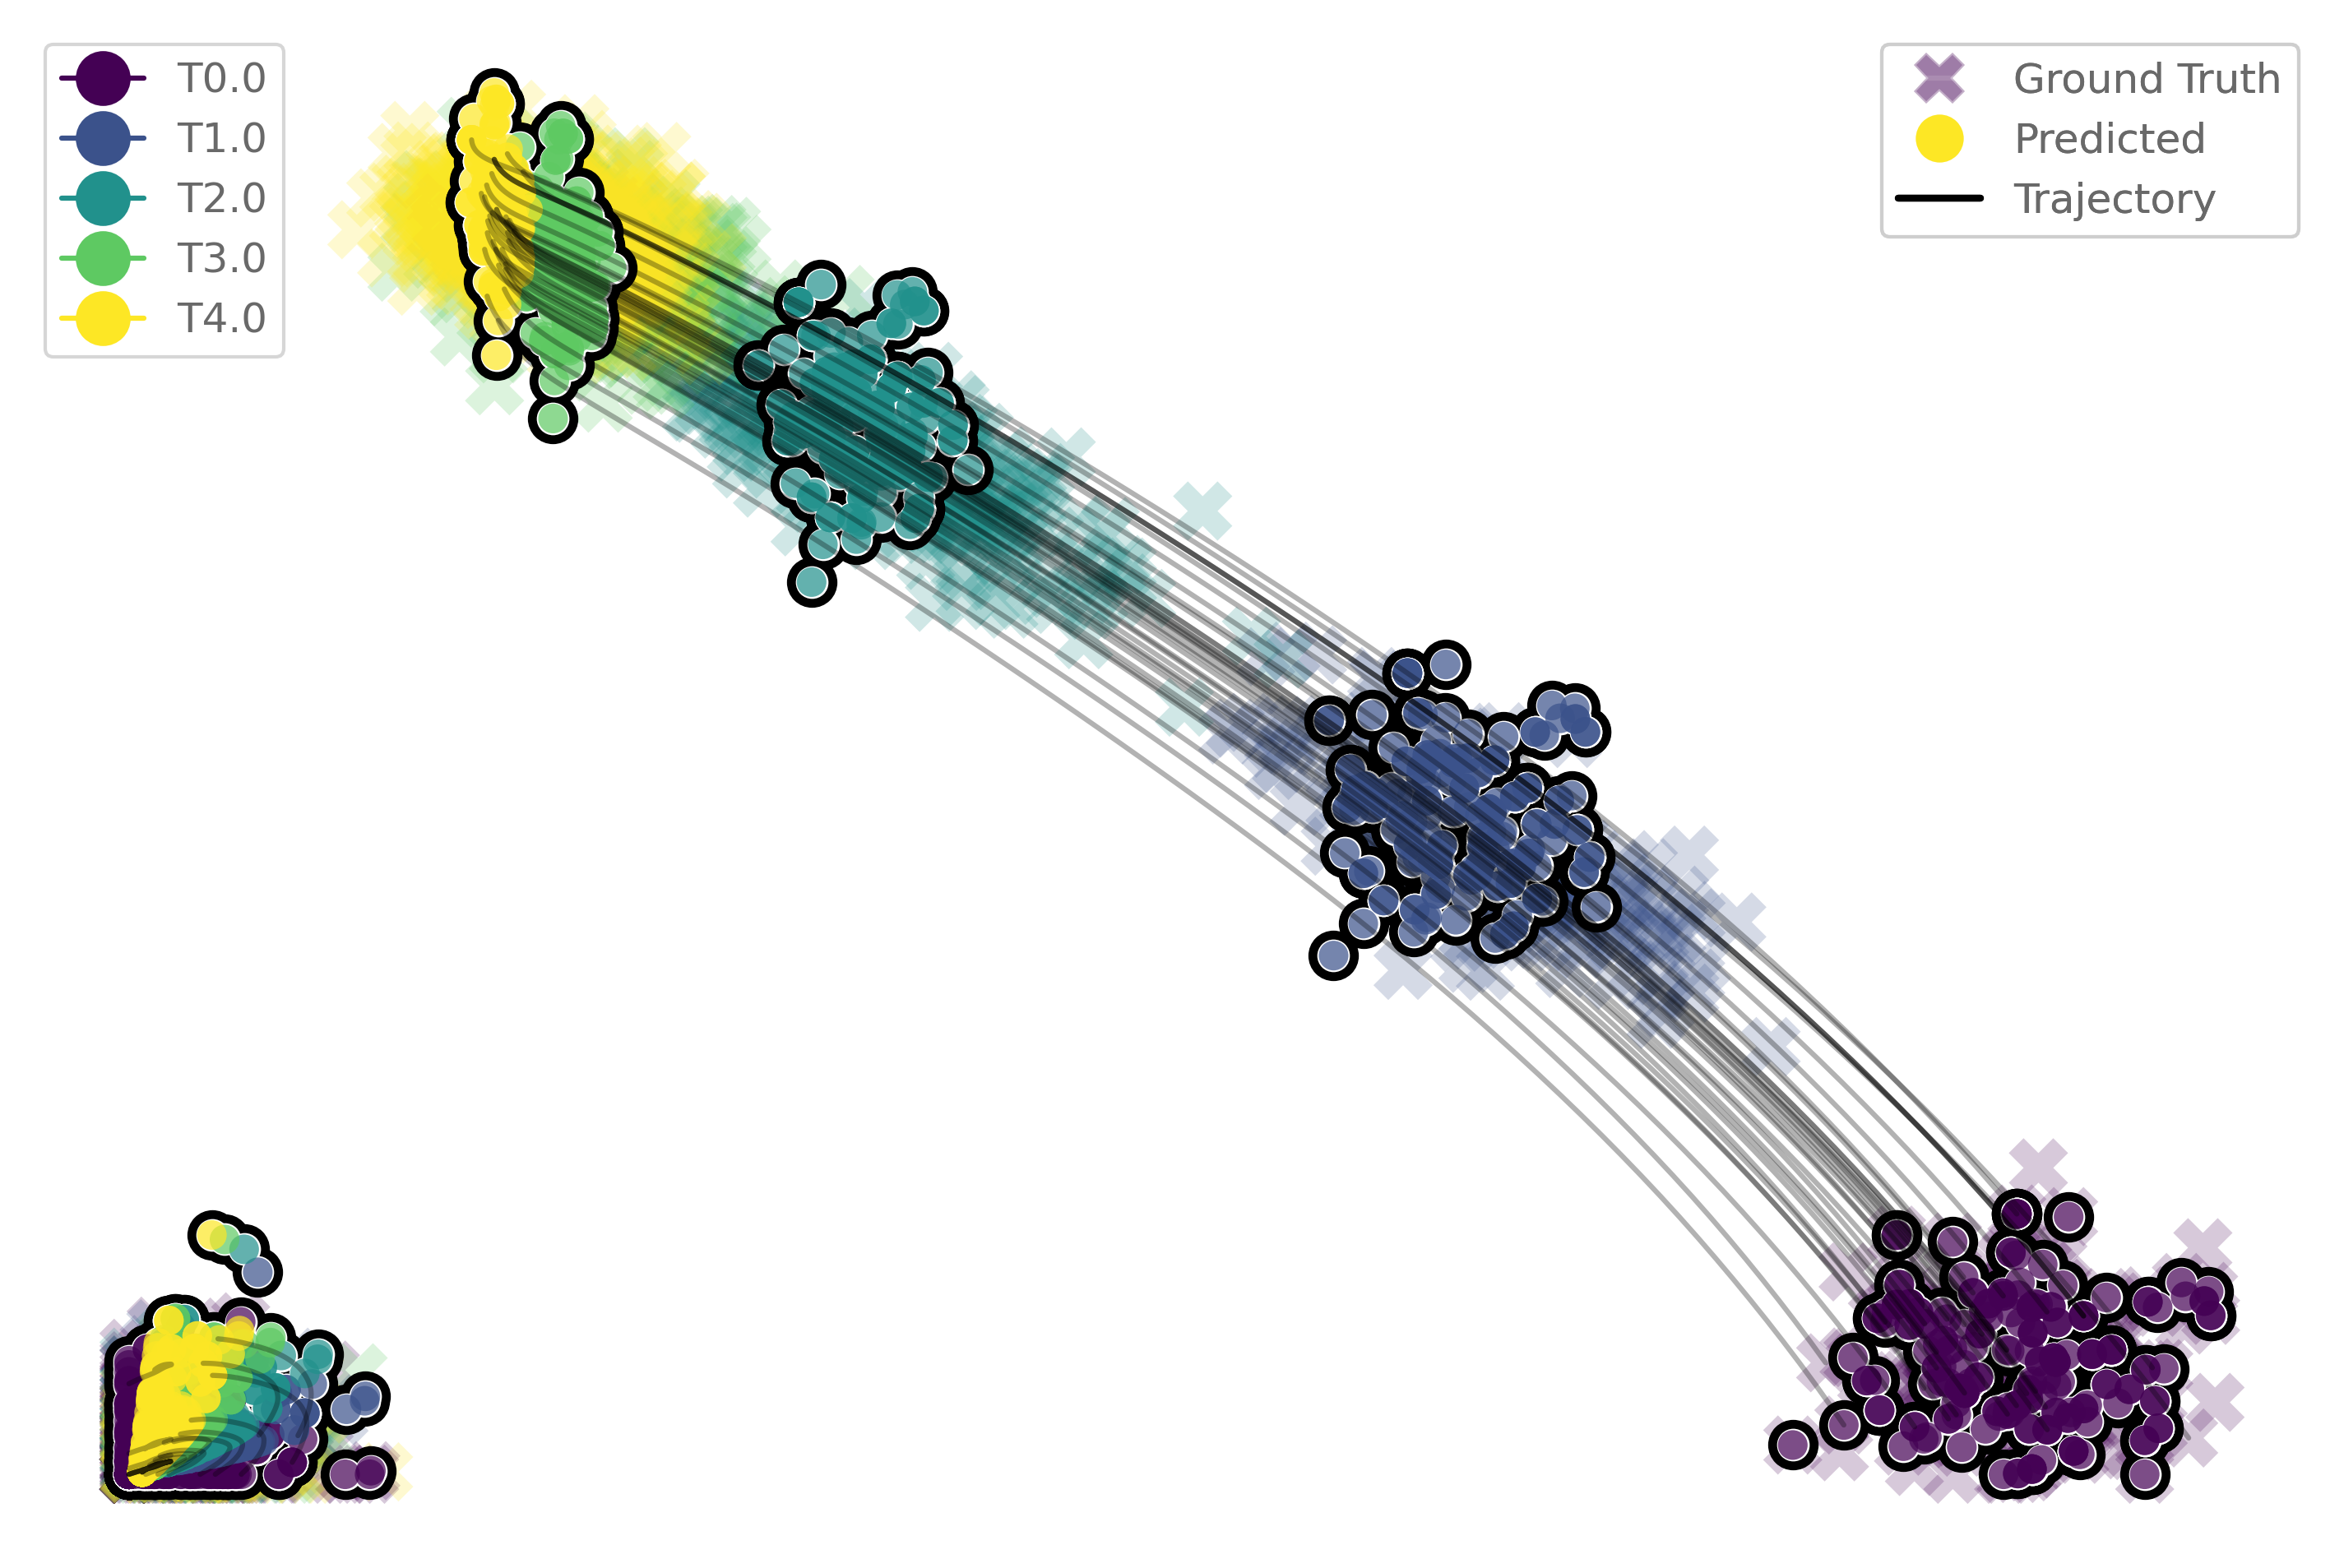

In [21]:
    plot_comparision(
        df, generated, trajectories,
        palette = 'viridis', df_time_key='samples',
        save=True, path=exp_dir, file='comparision.png',
        x='x1', y='x2', is_3d=False
    )

In [22]:
f_net.to(device)
data=torch.tensor(df[df['samples']==0].values,dtype=torch.float32).requires_grad_()
data_t0 = data[:, 1:3].clone().detach().to(device).requires_grad_()

lnw0 = torch.log(torch.ones(sample_size[0],1,dtype=torch.float32) / (initial_size)).to(device).requires_grad_()  
initial_state_energy = (data_t0, lnw0)
t=torch.tensor([0.0,2.0],dtype=torch.float32).requires_grad_()
x_t, lnw_t=odeint(ODEFunc2(f_net),initial_state_energy,t,options=dict(step_size=0.01),method='euler')


final_mass=lnw_t[-1]
final_mass=torch.exp(final_mass)
weight=final_mass/final_mass.sum()

### Pretrain score

DataFrame shape: (3031, 3)
DataFrame columns: Index(['samples', 'x1', 'x2'], dtype='object')
obsm_data shape: (3031, 2)
AnnData object with n_obs × n_vars = 3031 × 0
    obsm: 'X_pca'


/lustre/home/2301110060/software/miniconda3/envs/DeepRUOT/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/lustre/home/2301110060/software/miniconda3/envs/DeepRUOT/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


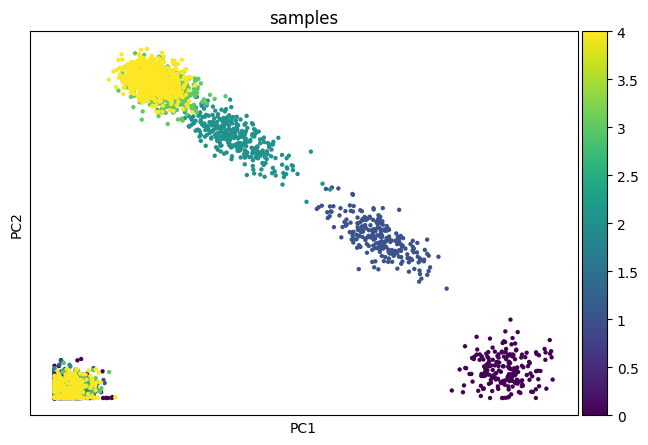

5


In [ ]:
import pandas as pd
import anndata as ad

f_net.load_state_dict(torch.load(os.path.join(exp_dir+'/best_model'),map_location=torch.device('cpu')))
f_net.to(device)

print("DataFrame shape:", df.shape)
print("DataFrame columns:", df.columns)
n=dim
samples = df['samples'].values
column_names = [f'x{i}' for i in range(1, n + 1)]

obsm_data = df[column_names].values
print("obsm_data shape:", obsm_data.shape)

adata = ad.AnnData(obs=pd.DataFrame(index=samples))


adata.obsm['X_pca'] = obsm_data


adata_loaded = adata


print(adata_loaded)

import scanpy as sc

adata.obs['samples']=df['samples'].values
sc.pl.scatter(adata, basis="pca", color="samples")

n_times = len(adata.obs["samples"].unique())
print(n_times)
X = [
    adata.obsm["X_pca"][adata.obs["samples"] == t]
    for t in range(n_times)
]

In [ ]:
from DeepRUOT.utils import OTPlanSampler, ConditionalFlowMatcher, ExactOptimalTransportConditionalFlowMatcher, TargetConditionalFlowMatcher,SchrodingerBridgeConditionalFlowMatcher, VariancePreservingConditionalFlowMatcher,generate_state_trajectory
from DeepRUOT.models import scoreNet2

batch_size = df[df['samples']==0].x1.shape[0]
sigma = 0.25
time = torch.Tensor(groups)
SF2M = SchrodingerBridgeConditionalFlowMatcher(sigma=sigma)
sf2m_score_model=scoreNet2(in_out_dim=dim, hidden_dim=128,  activation='leakyrelu').float().to(device)
sf2m_optimizer = torch.optim.Adam(
    list(sf2m_score_model.parameters()), 1e-4
)
trajectory = generate_state_trajectory(X, n_times,batch_size, f_net, time, device)

In [27]:
from DeepRUOT.utils import get_batch

max_norm_ut = torch.tensor(0.0)
lambda_penalty=0
for i in tqdm(range(3001)):
    sf2m_optimizer.zero_grad()
    t, xt, ut,eps = get_batch(SF2M, X, trajectory,batch_size, n_times, return_noise=True)
    t=torch.unsqueeze(t,1)
    lambda_t = SF2M.compute_lambda(t % 1)
    value_st=sf2m_score_model(t, xt)
    st = sf2m_score_model.compute_gradient(t, xt)
    positive_st = torch.relu(value_st)
    penalty = lambda_penalty * torch.max(positive_st)

    # max_norm_ut = torch.maximum(torch.max(torch.sum(ut**2, dim=1)), max_norm_ut)
    score_loss = torch.mean((lambda_t[:, None] * st + eps) ** 2)
    if i % 100 == 0:
        print(torch.max(positive_st))
        print(f"{i}:  {score_loss.item():0.2f}")
    loss = score_loss+penalty

    loss.backward()
    sf2m_optimizer.step()

  0%|          | 2/3001 [00:00<03:37, 13.77it/s]

tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
0:  0.99


  3%|▎         | 102/3001 [00:07<03:23, 14.26it/s]

tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
100:  0.82


  7%|▋         | 202/3001 [00:14<03:16, 14.25it/s]

tensor(0.0413, device='cuda:0', grad_fn=<MaxBackward1>)
200:  0.66


 10%|█         | 302/3001 [00:21<03:09, 14.23it/s]

tensor(0.2164, device='cuda:0', grad_fn=<MaxBackward1>)
300:  0.60


 13%|█▎        | 402/3001 [00:28<03:02, 14.26it/s]

tensor(0.4356, device='cuda:0', grad_fn=<MaxBackward1>)
400:  0.61


 17%|█▋        | 502/3001 [00:35<02:55, 14.26it/s]

tensor(0.6048, device='cuda:0', grad_fn=<MaxBackward1>)
500:  0.58


 20%|██        | 602/3001 [00:42<02:48, 14.25it/s]

tensor(0.6926, device='cuda:0', grad_fn=<MaxBackward1>)
600:  0.54


 23%|██▎       | 702/3001 [00:49<02:41, 14.26it/s]

tensor(0.7098, device='cuda:0', grad_fn=<MaxBackward1>)
700:  0.53


 27%|██▋       | 802/3001 [00:57<03:02, 12.07it/s]

tensor(0.5767, device='cuda:0', grad_fn=<MaxBackward1>)
800:  0.53


 30%|███       | 902/3001 [01:04<02:27, 14.25it/s]

tensor(0.4652, device='cuda:0', grad_fn=<MaxBackward1>)
900:  0.53


 33%|███▎      | 1002/3001 [01:11<02:20, 14.25it/s]

tensor(0.4627, device='cuda:0', grad_fn=<MaxBackward1>)
1000:  0.54


 37%|███▋      | 1102/3001 [01:18<02:13, 14.24it/s]

tensor(0.4661, device='cuda:0', grad_fn=<MaxBackward1>)
1100:  0.54


 40%|████      | 1202/3001 [01:25<02:06, 14.27it/s]

tensor(0.4728, device='cuda:0', grad_fn=<MaxBackward1>)
1200:  0.55


 43%|████▎     | 1302/3001 [01:32<01:59, 14.27it/s]

tensor(0.4222, device='cuda:0', grad_fn=<MaxBackward1>)
1300:  0.52


 47%|████▋     | 1402/3001 [01:39<01:52, 14.25it/s]

tensor(0.4192, device='cuda:0', grad_fn=<MaxBackward1>)
1400:  0.54


 50%|█████     | 1502/3001 [01:46<01:45, 14.25it/s]

tensor(0.5344, device='cuda:0', grad_fn=<MaxBackward1>)
1500:  0.53


 53%|█████▎    | 1602/3001 [01:53<01:38, 14.25it/s]

tensor(0.5400, device='cuda:0', grad_fn=<MaxBackward1>)
1600:  0.54


 57%|█████▋    | 1702/3001 [02:00<01:31, 14.25it/s]

tensor(0.5698, device='cuda:0', grad_fn=<MaxBackward1>)
1700:  0.52


 60%|██████    | 1802/3001 [02:07<01:24, 14.25it/s]

tensor(0.4072, device='cuda:0', grad_fn=<MaxBackward1>)
1800:  0.50


 63%|██████▎   | 1902/3001 [02:14<01:17, 14.23it/s]

tensor(0.1181, device='cuda:0', grad_fn=<MaxBackward1>)
1900:  0.52


 67%|██████▋   | 2002/3001 [02:21<01:10, 14.25it/s]

tensor(0.2270, device='cuda:0', grad_fn=<MaxBackward1>)
2000:  0.49


 70%|███████   | 2102/3001 [02:28<01:02, 14.27it/s]

tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
2100:  0.53


 73%|███████▎  | 2202/3001 [02:35<00:56, 14.27it/s]

tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
2200:  0.48


 77%|███████▋  | 2302/3001 [02:42<00:49, 14.25it/s]

tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
2300:  0.47


 80%|████████  | 2402/3001 [02:49<00:41, 14.27it/s]

tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
2400:  0.53


 83%|████████▎ | 2502/3001 [02:56<00:35, 14.25it/s]

tensor(0.1869, device='cuda:0', grad_fn=<MaxBackward1>)
2500:  0.49


 87%|████████▋ | 2602/3001 [03:03<00:28, 14.23it/s]

tensor(0.2245, device='cuda:0', grad_fn=<MaxBackward1>)
2600:  0.55


 90%|█████████ | 2702/3001 [03:10<00:20, 14.27it/s]

tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
2700:  0.50


 93%|█████████▎| 2802/3001 [03:17<00:13, 14.26it/s]

tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
2800:  0.50


 97%|█████████▋| 2902/3001 [03:24<00:06, 14.27it/s]

tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
2900:  0.46


100%|██████████| 3001/3001 [03:31<00:00, 14.21it/s]

tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
3000:  0.48


In [28]:
torch.save(sf2m_score_model.state_dict(), os.path.join(exp_dir, 'score_model'))

torch.Size([10000, 1])
torch.Size([10000, 2])


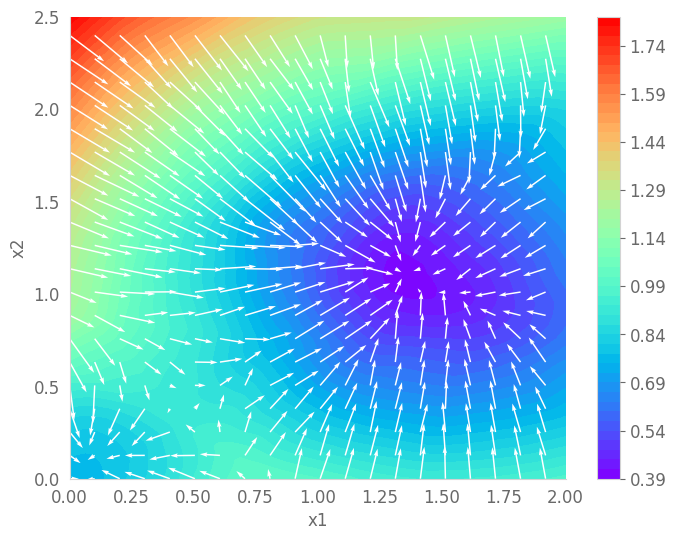

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import torch



x_range = np.linspace(0, 2, 100)
y_range = np.linspace(0, 2.5, 100)
xv, yv = np.meshgrid(x_range, y_range)
grid_points = np.stack([xv, yv], axis=-1).reshape(-1, 2)

grid_points_tensor = torch.tensor(grid_points).float().to(device)

expanded_tensor = grid_points_tensor

t_value = 1.0  
t_tensor = torch.tensor([t_value] * grid_points.shape[0]).unsqueeze(1).float().to(device)
print(t_tensor.shape)

expanded_tensor.requires_grad_(True)
log_density_values = sf2m_score_model(t_tensor, expanded_tensor)

density_values=torch.exp(log_density_values)

log_density_values.backward(torch.ones_like(log_density_values))
gradients = expanded_tensor.grad
print(gradients.shape)
gradients_np = gradients.cpu().detach().numpy().reshape(100, 100, 2)

step = 5
xv_quiver = xv[::step, ::step]
yv_quiver = yv[::step, ::step]
gradients_np_quiver = gradients_np[::step, ::step, :]

plt.figure(figsize=(8, 6))
plt.contourf(xv, yv, -log_density_values.cpu().detach().numpy().reshape(100, 100), levels=50, cmap='rainbow')
plt.colorbar(label=' ')
plt.quiver(xv_quiver, yv_quiver, gradients_np_quiver[:, :, 0], gradients_np_quiver[:, :, 1], color='white', scale=10)
plt.xlabel('x1')
plt.ylabel('x2')
#plt.savefig('score_t_0_gaussian.pdf')
plt.show()

### Train

In [31]:
sf2m_score_model.load_state_dict(torch.load(os.path.join(exp_dir, 'score_model'),map_location=torch.device('cpu')))
sf2m_score_model.to(device)
f_net.load_state_dict(torch.load(os.path.join(exp_dir+'/best_model'),map_location=torch.device('cpu')))
f_net.to(device)

FNet(
  (v_net): velocityNet(
    (activation): LeakyReLU(negative_slope=0.01)
    (net): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=3, out_features=128, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (1-2): 2 x Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
    )
    (out): Linear(in_features=128, out_features=2, bias=True)
  )
  (g_net): growthNet(
    (activation): LeakyReLU(negative_slope=0.01)
    (net): Sequential(
      (0): Linear(in_features=3, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=128, out_features=1, bias=True)
    )
  )
  (s_net): scoreNet(
    (activation): LeakyReLU(negative_

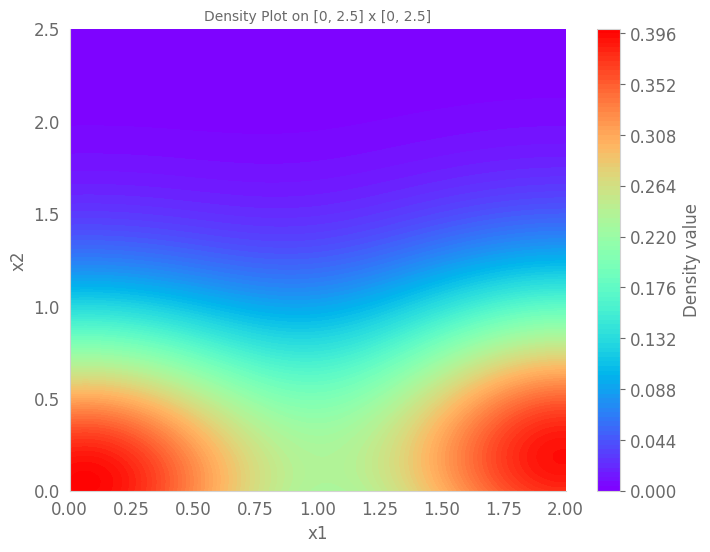

In [44]:
import numpy as np
from DeepRUOT.utils import density1
import matplotlib.pyplot as plt
import torch

datatime0=torch.zeros(df[df['samples']==0].x1.shape[0],2)
datatime0[:,0]=torch.tensor(df[df['samples']==0].x1)
datatime0[:,1]=torch.tensor(df[df['samples']==0].x2)
device='cpu'

x_range = np.linspace(0, 2, 100)
y_range = np.linspace(0, 2.5, 100)
xv, yv = np.meshgrid(x_range, y_range)
grid_points = np.stack([xv, yv], axis=-1).reshape(-1, 2)

grid_points_tensor = torch.tensor(grid_points).float().to(device)

with torch.no_grad():
    function_values = density1(grid_points_tensor,datatime0,device).cpu().detach().numpy().reshape(100, 100)
    
plt.figure(figsize=(8, 6))
plt.contourf(xv, yv, function_values, levels=100, cmap='rainbow')
plt.colorbar(label='Density value')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Density Plot on [0, 2.5] x [0, 2.5]')
plt.show()

In [45]:
from DeepRUOT.train import train_all
device='cpu'
optimizer = torch.optim.SGD(list(f_net.parameters())+list(sf2m_score_model.parameters()),1e-5)


In [46]:

    if n_local_epochs > 0:
        logger.info(f'Beginning Training')
        for epoch in tqdm(range(1), desc='Training Epoch'):
            l_loss, b_loss, g_loss = train_all(
                f_net, df, groups, optimizer,10,
                criterion = criterion, use_cuda = use_cuda,
                local_loss=True, global_loss=False, apply_losses_in_time=apply_losses_in_time,
                hold_one_out=hold_one_out, hold_out=hold_out, sf2m_score_model=sf2m_score_model,
                 hinge_value=hinge_value,datatime0=datatime0,device=device, lambda_initial=0.1,
                 use_pinn=True, use_penalty=True,use_density_loss=False,lambda_density=10,
                top_k = top_k, sample_size = sample_size,relative_mass=relative_mass,initial_size=initial_size,
                sample_with_replacement = sample_with_replacement, logger=logger, sigmaa=sigma,lambda_pinn=1,
            )
            for k, v in l_loss.items():  
                local_losses[k].extend(v)
            batch_losses.extend(b_loss)
            globe_losses.extend(g_loss)


Training Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

begin local loss


  0%|          | 0/10 [00:00<?, ?it/s]

Otloss
tensor(0.0328, grad_fn=<SumBackward0>)
mass loss
tensor(0.0112, grad_fn=<PowBackward0>)
energy loss
tensor(0.0008, grad_fn=<MeanBackward0>)
pinloss
0
Otloss
tensor(0.0667, grad_fn=<SumBackward0>)
mass loss
tensor(0.0469, grad_fn=<PowBackward0>)
energy loss
tensor(0.0020, grad_fn=<MeanBackward0>)
pinloss
0
Otloss
tensor(0.0883, grad_fn=<SumBackward0>)
mass loss
tensor(0.1090, grad_fn=<PowBackward0>)
energy loss
tensor(0.0035, grad_fn=<MeanBackward0>)
pinloss
0
Otloss
tensor(0.0804, grad_fn=<SumBackward0>)
mass loss
tensor(0.3514, grad_fn=<PowBackward0>)
energy loss
tensor(0.0055, grad_fn=<MeanBackward0>)
pinloss
0
Otloss
tensor(0.0328, grad_fn=<SumBackward0>)
mass loss
tensor(0.0112, grad_fn=<PowBackward0>)
energy loss
tensor(0.0008, grad_fn=<MeanBackward0>)
pinloss
0
Otloss
tensor(0.0667, grad_fn=<SumBackward0>)
mass loss
tensor(0.0472, grad_fn=<PowBackward0>)
energy loss
tensor(0.0020, grad_fn=<MeanBackward0>)
pinloss
0
Otloss
tensor(0.0882, grad_fn=<SumBackward0>)
mass loss
te

Training Epoch: 100%|██████████| 1/1 [00:12<00:00, 12.17s/it]


In [32]:
torch.save(sf2m_score_model.state_dict(), os.path.join(exp_dir, 'score_model_result'))
torch.save(f_net.state_dict(), os.path.join(exp_dir, 'model_result'))

In [33]:
data=torch.tensor(df[df['samples']==0].values,dtype=torch.float32).requires_grad_()
data_t0 = data[:, 1:dim+1].to(device).requires_grad_()
print(data_t0.shape)
x0=data_t0.to(device)

torch.Size([400, 2])


In [34]:
import torchsde
class SDE(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, ode_drift, score, input_size=(3, 32, 32), sigma=1.0):
        super().__init__()
        self.drift = ode_drift
        self.score = score
        self.input_size = input_size
        self.sigma = sigma

    # Drift
    def f(self, t, y):
        drift=self.drift(t,y)
        num = y.shape[0]
        t = t.expand(num, 1) 
        return drift+self.score.compute_gradient(t,y)

    # Diffusion
    def g(self, t, y):
        return torch.ones_like(y)*sigma


sde = SDE(f_net.v_net, sf2m_score_model, input_size=(dim,), sigma=sigma)
sde_traj = torchsde.sdeint(
        sde,
        x0.to(device),
        dt=0.01,
        ts=torch.linspace(0, n_times - 1, 400, device=device),
    ).cpu()

In [35]:
# define sample_number
sample_number = 10 

sample_indices = random.sample(range(sde_traj.size(1)), sample_number)

sampled_sde_trajec = sde_traj[:, sample_indices, :]

sampled_sde_trajec.shape


sampled_sde_trajec = sampled_sde_trajec.tolist()

sampled_sde_trajec = np.array(sampled_sde_trajec, dtype=object)

np.save(exp_dir+'/sde_trajec_our_post_plot.npy', sampled_sde_trajec)


In [36]:
ts_points=time.to(device)
ts_points

sde_point = torchsde.sdeint(
        sde,
        x0.to(device),
        dt=0.01,
        ts=ts_points,
    ).cpu()

In [37]:
sde_point_np = sde_point.detach().numpy()

sde_point_list = sde_point_np.tolist()

sde_point_array = np.array(sde_point_list, dtype=object)

np.save(exp_dir+'/sde_point_our_post.npy', sde_point_array)



In [38]:
sde_point_our_post=np.load(exp_dir+'/sde_point_our_post.npy',allow_pickle=True)


In [39]:
from DeepRUOT.plots import new_plot_comparisions2

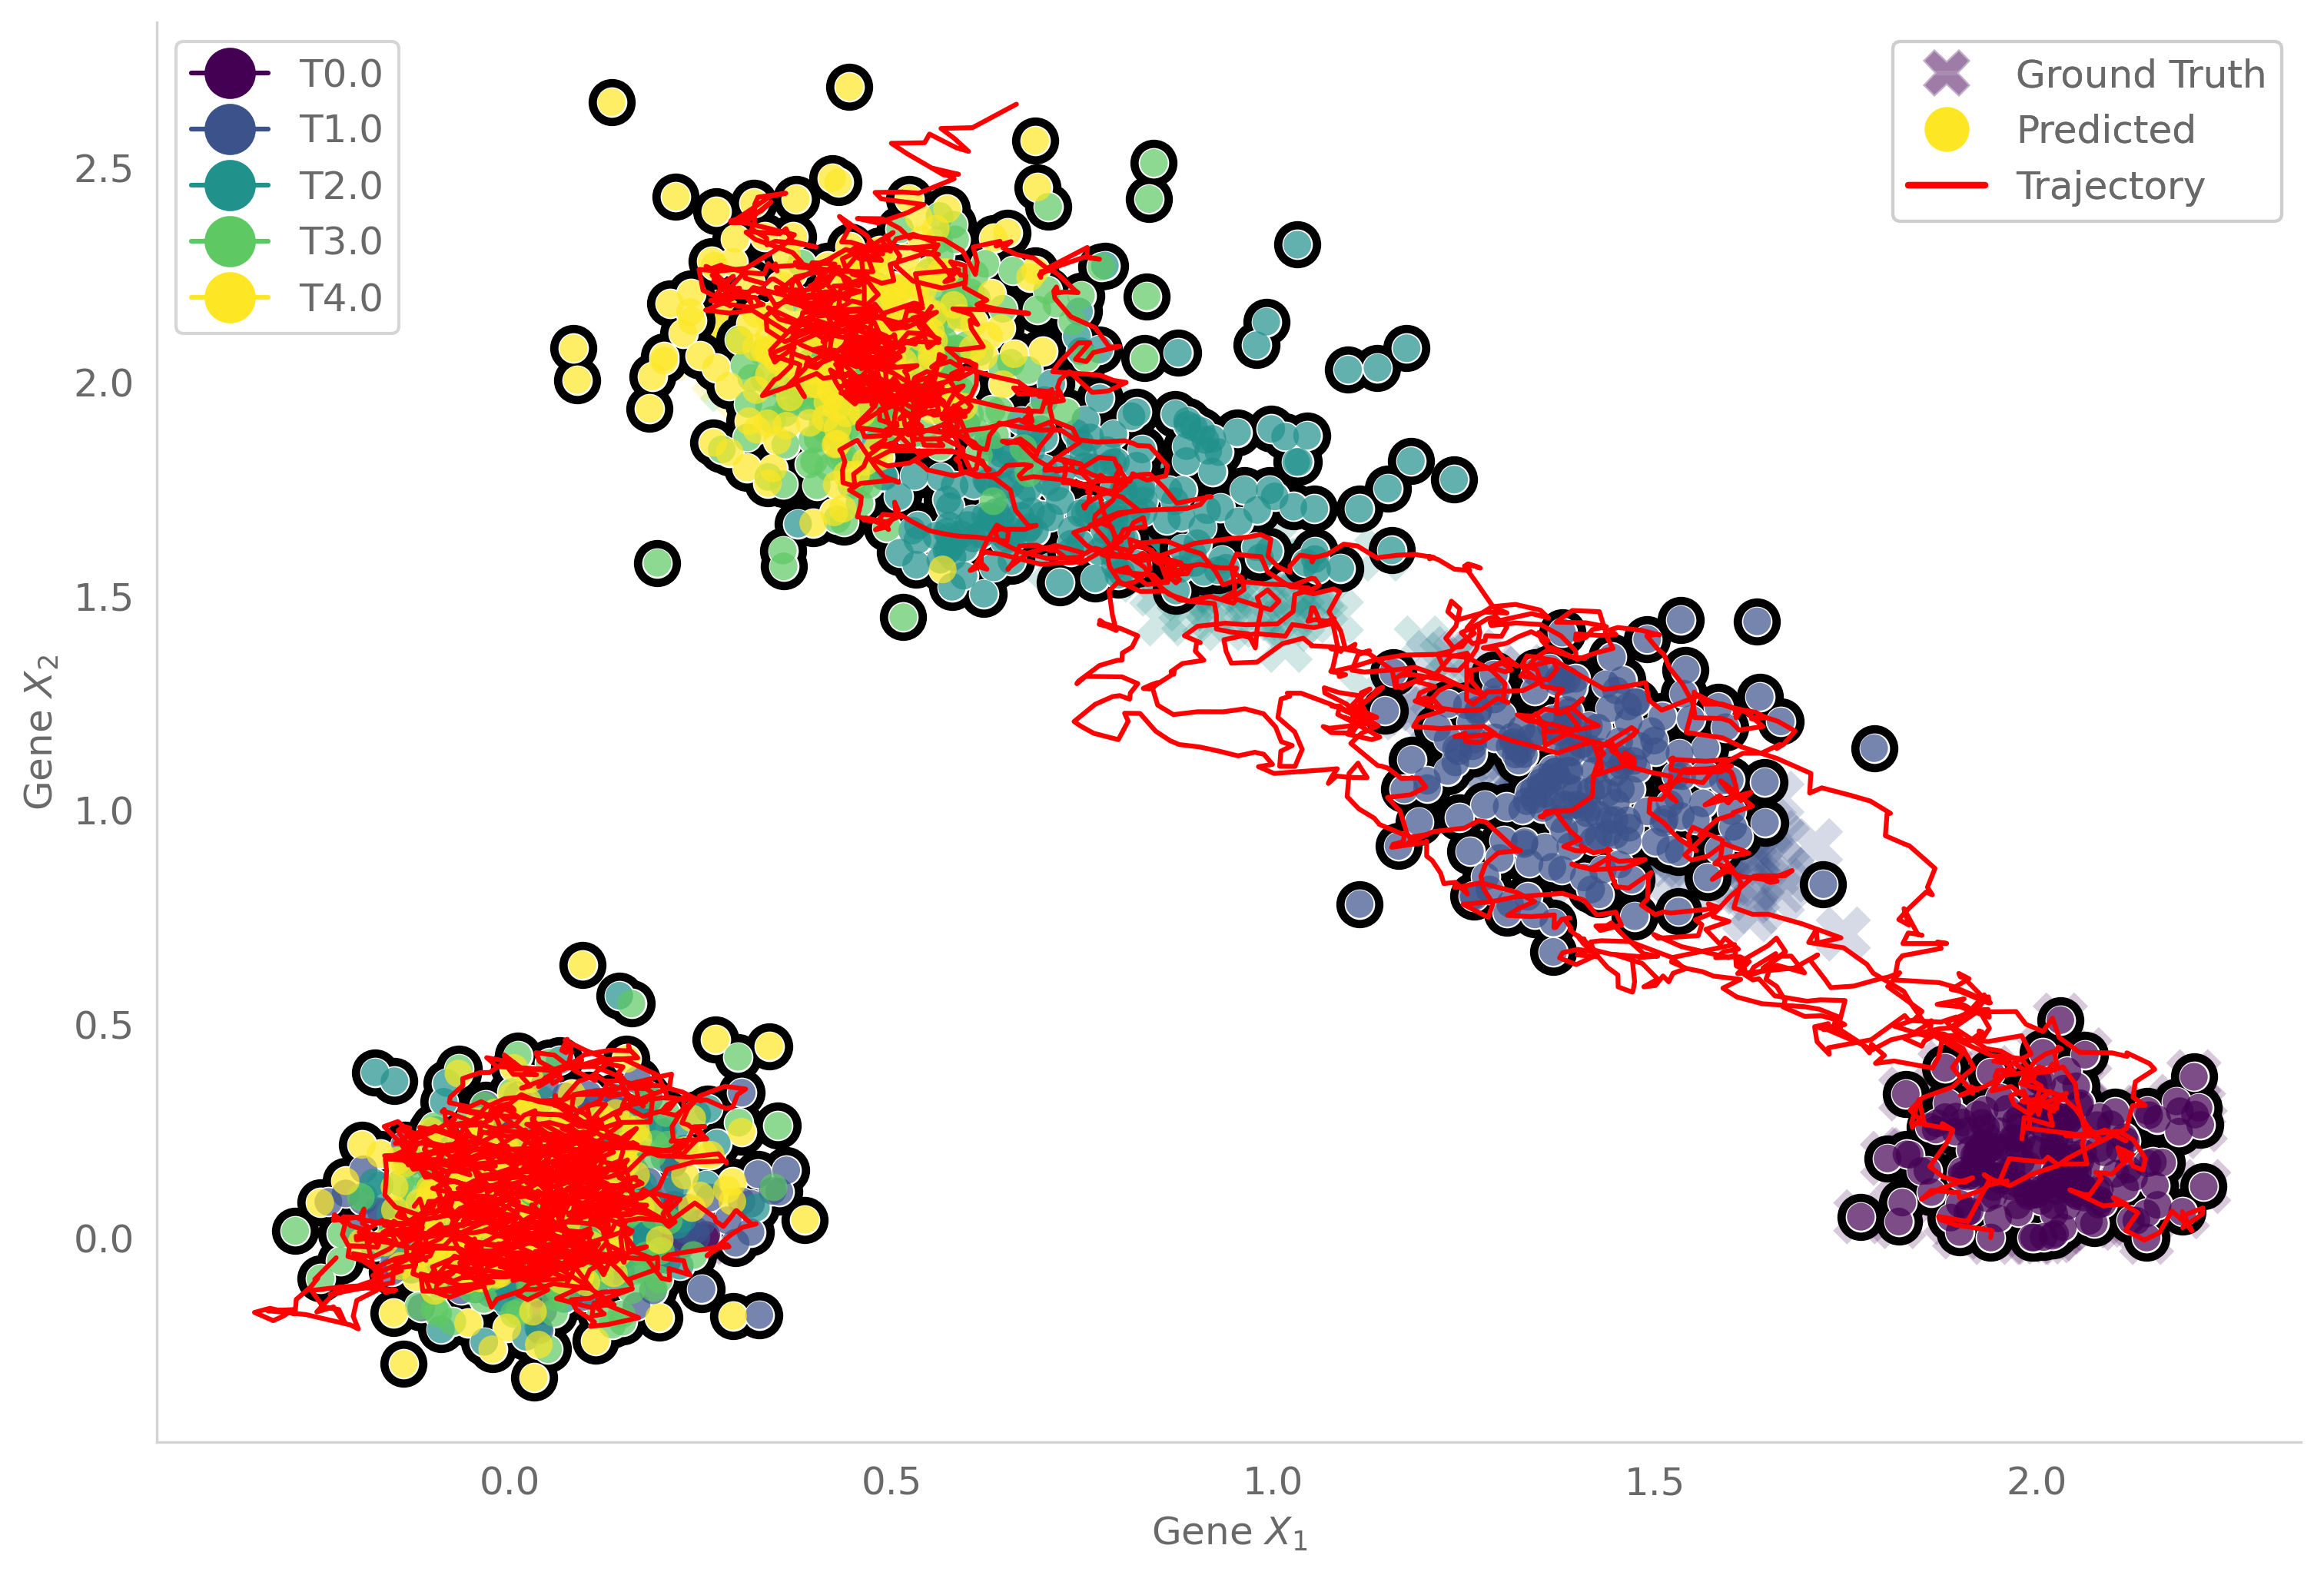

In [40]:
sde_trajec_our_post_plot=np.load(exp_dir+'/sde_trajec_our_post_plot.npy',allow_pickle=True)
new_plot_comparisions2(
        df, sde_point_our_post, sde_trajec_our_post_plot,
        palette = 'viridis', df_time_key='samples',
        save=True, path=exp_dir, file='sde_trajec_our_post_plot.pdf',
        x='x1', y='x2', z='x3',is_3d=False
    )